In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
import mlflow

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from hyperopt.pyll.base import scope

# reset color and other runtime configs
plt.rcParams.update(plt.rcParamsDefault)

%matplotlib inline

# apply a ploting style
plt.style.use("seaborn-v0_8-talk")

In [2]:
mlflow_tracking_url = "sqlite:///data/mlflow.db"
mlflow.set_tracking_uri(mlflow_tracking_url)
mlflow.set_experiment("trotro-duration-experiment2")

<Experiment: artifact_location='/Users/asare/source/trotro_mlops/mlruns/3', creation_time=1730100029569, experiment_id='3', last_update_time=1730100029569, lifecycle_stage='active', name='trotro-duration-experiment2', tags={}>

In [3]:
categorical_features = ["PULocationID", "DOLocationID", "RatecodeID"]
numerical_features = ["trip_distance", "passenger_count", "hour_of_day"]
target = "duration"


def load_data(filename):
    df = pd.read_parquet(filename)
    df = df[df.passenger_count > 0]

    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["duration"] = df["duration"].dt.total_seconds() / 60
    df["hour_of_day"] = df.tpep_pickup_datetime.dt.hour
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical_features = ["PULocationID", "DOLocationID", "RatecodeID"]
    numerical_features = ["trip_distance", "passenger_count", "hour_of_day", "duration"]
    df[categorical_features] = df[categorical_features].astype(int).astype(str)
    df = df[categorical_features + numerical_features]

    return df


def hyperparameter_tuning():
    print("loading data...")
    df_train = load_data("./data/yellow_tripdata_2024-01.parquet")
    df_val = load_data("./data/yellow_tripdata_2024-02.parquet")

    train_dicts = df_train[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    val_dicts = df_val[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    print("preprocessing data...")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train[target].values

    X_val = dv.transform(val_dicts)
    y_val = df_val[target].values

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    mlflow.log_param("train_dataset", "./data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("validation_dataset", "./data/yellow_tripdata_2024-02.parquet")

    def objective(params):
        with mlflow.start_run(nested=True):
            mlflow.log_params(params)
            mlflow.set_tag("model", "xgboost")
            mlflow.set_tag("process", "hyperparameter_tuning")

            xgb_model = xgb.train(
                params,
                dtrain,
                num_boost_round=10,
                evals=[(dval, "validation")],
                early_stopping_rounds=5,
            )
            y_pred = xgb_model.predict(dval)
            rmse = root_mean_squared_error(y_val, y_pred)
            mlflow.log_metric("rmse", rmse)

            return {"loss": rmse, "status": STATUS_OK}

    search_space = {
        "learning_rate": hp.loguniform("learning_rate", -3, 0),
        "max_depth": scope.int(hp.quniform("max_depth", 1, 10, 1)),
        "objective": "reg:squarederror",
        "seed": 42,
    }

    print("optimizing hyperparameters...")
    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=10,
        trials=Trials(),
    )

    best_params = space_eval(search_space, best_result)
    print(f"best hyperparameters: {best_params}")

    return best_params


def train_model(params):
    print(f"training model with optimized hyperparameters {params}")

    df_train = load_data("./data/yellow_tripdata_2024-01.parquet")
    df_val = load_data("./data/yellow_tripdata_2024-02.parquet")

    train_dicts = df_train[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    val_dicts = df_val[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    print("preprocessing data...")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train[target].values

    X_val = dv.transform(val_dicts)
    y_val = df_val[target].values

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    
   
    mlflow.log_param("train_dataset", "./data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("validation_dataset", "./data/yellow_tripdata_2024-02.parquet")
    mlflow.log_param("estimator", "XGBRegressor")
    mlflow.log_param("train_samples", df_train.shape[0])
    mlflow.log_param("validation_samples", df_val.shape[0])
    mlflow.log_param("features", categorical_features + numerical_features)
    mlflow.log_param("target", target)

    mlflow.xgboost.autolog()
    xgb_model = xgb.train(
        params,
        dtrain,
        num_boost_round=10,
        evals=[(dval, "validation")],
        early_stopping_rounds=5,
    )

    y_pred_val = xgb_model.predict(dval)
    y_pred_train = xgb_model.predict(dtrain)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)
    mlflow.log_metric("rmse", rmse_val)
    print(f"RMSE: {rmse_val:.2f}")

    fig_train = plot_pred_distribution(
        y=y_train,
        y_pred=y_pred_train,
        y_label="Actual (Train dataset)",
        y_pred_label="Predicted (Train dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )
    mlflow.log_figure(fig_train, "train_dist.png")

    fig_val = plot_pred_distribution(
        y=y_val,
        y_pred=y_pred_val,
        y_label="Actual (Validation dataset)",
        y_pred_label="Predicted (Validation dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )

    mlflow.log_figure(fig_val, "val_dist.png")

    return dv, xgb_model


def validate_model(dv, model):
    df_val = load_data("./data/yellow_tripdata_2024-02.parquet")
    val_dicts = df_val[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    mlflow.log_param("validation_dataset", "./data/yellow_tripdata_2024-02.parquet")
    X_val = dv.transform(val_dicts)
    y_val = df_val[target].values

    y_pred = model.predict(X_val)
    rmse_val = root_mean_squared_error(y_val, y_pred)
    print(f"RMSE: {rmse_val:.2f}")
    mlflow.log_metric("rmse", rmse_val)

    fig = plot_pred_distribution(
        y=y_val,
        y_pred=y_pred,
        y_label="Actual (Validation dataset)",
        y_pred_label="Predicted (Validation dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )
    mlflow.log_figure(fig, "val_dist.png")


def predict(data, model_filename):
    val_dicts = data[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    dv, model = load_model(model_filename)
    X_val = dv.transform(val_dicts)
    y_pred = model.predict(X_val)
    data["predicted_duration"] = y_pred
    return data


def save_model(model, filename):
    path = f"./models/{filename}"
    with open(path, "wb") as f_out:
        pickle.dump(model, f_out)


def load_model(filename):
    path = f"./models/{filename}"
    with open(path, "rb") as f_in:
        return pickle.load(f_in)


def plot_pred_distribution(y, y_pred, y_label, y_pred_label, x_label, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(y, label=y_label, fill=True)
    sns.kdeplot(y_pred, label=y_pred_label, fill=True)
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend()
    plt.show()
    return fig


def main():
    with mlflow.start_run():
        best_result = hyperparameter_tuning()
        dv, model = train_model(params=best_result)
        #validate_model(dv, model)

loading data...
preprocessing data...
optimizing hyperparameters...
[0]	validation-rmse:9.18132                           
[1]	validation-rmse:8.24355                           
[2]	validation-rmse:7.50116                           
[3]	validation-rmse:6.91845                           
[4]	validation-rmse:6.46852                           
[5]	validation-rmse:6.12282                           
[6]	validation-rmse:5.85460                           
[7]	validation-rmse:5.65139                           
[8]	validation-rmse:5.49583                           
[9]	validation-rmse:5.37582                           
[0]	validation-rmse:8.37477                                                    
[1]	validation-rmse:7.05822                                                    
[2]	validation-rmse:6.20614                                                    
[3]	validation-rmse:5.66684                                                    
[4]	validation-rmse:5.33322                                   

2024/10/28 20:33:26 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/10/28 20:33:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/trotro/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:26] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
python(10965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2024/10/28 20:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RMSE: 4.72


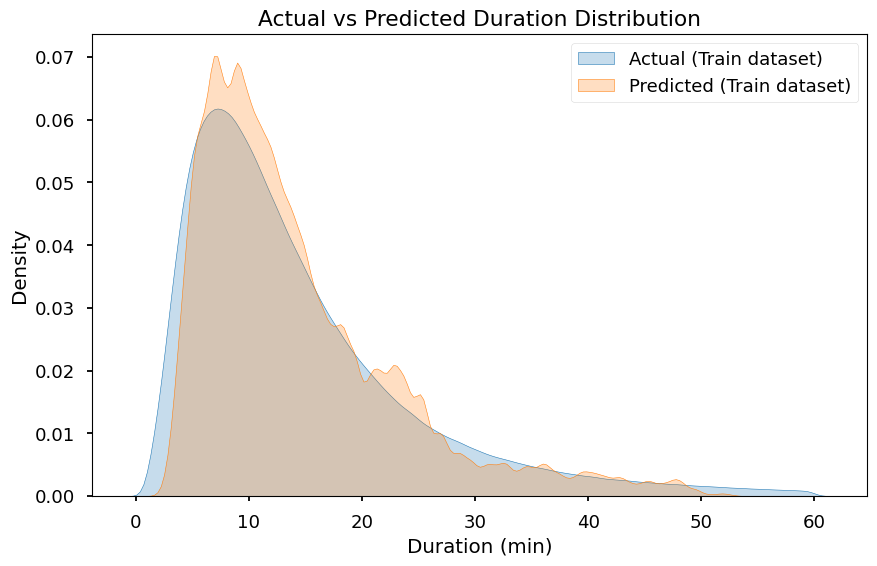

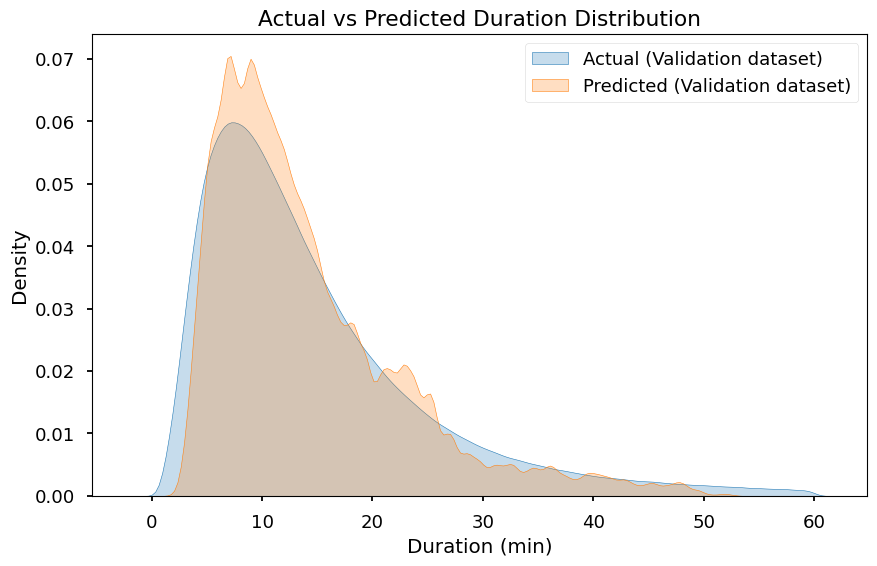

In [4]:
main()